In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import numpy as nd
import matplotlib.pyplot as plt
import IPython


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
#load the .mat file and read it into a dictionary
mnist_dict = loadmat("../Project1/data/mnistTrn.mat")

In [7]:
mnist_dict

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Sep 25 23:54:14 2016',
 '__version__': '1.0',
 'trn': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'trnAns': array([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [8]:
#Construct input and target datasets from the dictionary
mnist_input = mnist_dict['trn']
mnist_target = mnist_dict['trnAns']
print(nd.shape(mnist_input),nd.shape(mnist_target))

(784, 50000) (10, 50000)


In [9]:
#create test and train datasets
x_train,x_test,y_train,y_test = train_test_split(mnist_input.T,mnist_target.T,test_size = 0.3,random_state=123)
type(x_train)

numpy.ndarray

In [ ]:
# %load SOMLayer.py
"""
Created on Sun Nov  5 06:40:19 2017

@author: Shreshtha Kulkarni
"""
    
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

#Defines a particular node of the SOM.
#members: codebook_vec or weights, position assuming rectangular topography
#         input_vec_len: dimensions/features in input_data
#         lattice_type: shape of neighborhood area: rectangle/hexagon
class Node:
     #initialize node   
    def __init__(self,pos_x,pos_y,input_vec_len,lattice_type):
        self.codebook_vec = np.random.rand(1,input_vec_len)
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.lattice_type = lattice_type
    
             
    #evaluate if the passed node is a neighbor
    def isMyNeighbor(self,node,infl_radius):
        dist = np.linalg.norm(np.array([self.pos_x,self.pos_y]) - np.array([node.pos_x,node.pos_y]))
        if((self.lattice_type == "rect") and (pow(dist,2) < pow(infl_radius,2))):
            return True
        
        if(self.lattice_type == "hex"):
            R = 1.5*np.sqrt(3)*infl_radius*infl_radius
            if(pow(dist,2) <= R):
                return True
        
        return False

#Defines the SOM network. This will take care of training, updating the learning
#parameters and wts/codebook_vecs
class SOMNetwork:
    
    #Initialise the network. Internally initializes each node individually.
    #params: no_neurons = no. of nodes
    #        input_vec_len = features in input data
    #        topo = topology of network: line if 1D, rect if 2D
    #        topo_x, topo_y = length,width of the rectangle
    #        eta_0 = Initial learning rate
    #        eta_decay_method = method to decay eta: lin <linear>, exp, inv (inverse)
    #        dist_method = distance metric to be used. default is euclidean
    #        lattice_type = as used in node distance computation. default:rect
    def __init__(self,no_neurons,input_vec_len,topo,topo_x,topo_y,eta_0,eta_decay_method
                 ,dist_method,neighborhood_fun,lattice_type):
        if lattice_type is None or lattice_type == "":
            lattice_type = "rect"
        
        if(topo == "line"):
            self.neuron_mat = [Node(0,x,input_vec_len,lattice_type) for x in range(no_neurons)]
        elif(topo == "rect"):
            self.neuron_mat = []
            if(topo_x*topo_y != no_neurons):
                raise ValueError("topo_x*topo_y should be equal to no_neurons")
            for x in range(topo_x):
                for y in range(topo_y):
                    self.neuron_mat.append(Node(x,y,input_vec_len,lattice_type))
        else:
            raise ValueError("Unsupported topology type. Valid type: line,rect")
            
        self.no_neurons = no_neurons
        self.topo = topo
        self.tau_1 = 1000 #some constants to decay influence radius
        self.tau_2 = 1000 #constant to decay learning rate
        self.eta = eta_0
        self.eta_0 = eta_0
        
        self.infl_radius_0 = 1 if topo== "line" else np.linalg.norm([topo_x,topo_y])
        self.infl_radius = self.infl_radius_0
        
        if(dist_method  == "" or dist_method == None):
            self.dist_method = "euclidean"
        else:
            self.dist_method = dist_method
        
        if(eta_decay_method in ["exp","lin","inv"]):
            self.eta_decay_method = eta_decay_method
        elif(eta_decay_method == "" or eta_decay_method == None):
            self.eta_decay_method = "exp"
        else:
            raise ValueError("Invalid value %s for eta_decay_method.Valid are exp, lin or inv" %(eta_decay_method))
            
        if(neighborhood_fun in ["gaussian","bubble"]):
            self.neighborhood_func = neighborhood_fun
        elif(neighborhood_fun == "" or neighborhood_fun == None):
            self.neighborhood_func = "gaussian"
        else:
            raise ValueError("Invalid value %s for neighborhood_fun.Valid are gaussian or bubble" %(neighborhood_fun))
    
    #Get the best matching unit
    def getBMU(self,input_vec):       
        wt_mat = []
        for i in range(self.no_neurons):
            wt_mat.append(self.neuron_mat[i].codebook_vec[0])
        #from IPython.core.debugger import Tracer; Tracer()()
        res = pairwise_distances_argmin_min(np.array(input_vec).reshape(1,-1),wt_mat,metric = self.dist_method)
            
        return (self.neuron_mat[res[0][0]],res[1][0])
    
    #Decay learning rate
    def setDecayedEta(self,epoch):
        if(self.eta_decay_method == "exp"):
            self.eta = self.eta_0 * np.exp(-epoch/self.tau_2) #Exponential decay
        elif(self.eta_decay_method == "lin"):
            self.eta = self.eta_0 *(1- epoch/self.tau_2) #linear decay
        else:
            self.eta = self.eta_0/(epoch+1) #inverse decay
    
    #Decay influence radius
    def setDecayedInfluenceRadius(self,epoch):
        self.infl_radius = self.infl_radius_0 * np.exp(-epoch/self.tau_1)
    
    #Calculate influence value as per a guassian distribution function
    def calculateInfluenceValue(self,neighbor_node,bmu_node):
        #calculate the positional distance in the topographic map of SOM.
        #Its not the distance between wt vectors
        dist = np.linalg.norm(np.array([bmu_node.pos_x,bmu_node.pos_y])-
                                  np.array([neighbor_node.pos_x,neighbor_node.pos_y]))
        #dist=1
        return np.exp(-pow(dist,2)/(2*pow(self.infl_radius,2)))
    
    #Update the codebook vectors
    def updateWeights(self,bmu_node,neighbor_node,input_vec):
        #from IPython.core.debugger import Tracer; Tracer()()
        if(self.neighborhood_func == "gaussian"):
            infl_val = self.calculateInfluenceValue(neighbor_node,bmu_node)
            neighbor_node.codebook_vec += self.eta*infl_val*(input_vec - neighbor_node.codebook_vec)
        else:
            neighbor_node.codebook_vec += self.eta*(input_vec - neighbor_node.codebook_vec) #bubble update

    def updateParameters(self,epoch):
        if(self.eta > 0.01):
            self.setDecayedEta(epoch)
        #Do not update influence radius when it is very small.Assuming that
        #neighboorhood has already reduce to single neuron
        if(self.infl_radius > 0.001):
            self.setDecayedInfluenceRadius(epoch)
    
    #Finp the neighbors of BMU.
    def findNeighbors(self,bmu_node):
        bmu_node_ind = self.neuron_mat.index(bmu_node)
        neighbor_coords = []
                
        if(self.topo == "line"):
            if(self.infl_radius < 1):
                return neighbor_coords #return empty neighbors as neighborhood has shrunk to single neuron
                                       #else infl_val becomes too small producing NaNs in wt update.
            if(bmu_node_ind == 0): #if end neuron
                neighbor_coords.append(1) 
            elif(bmu_node_ind == (len(self.neuron_mat)-1)): #if other end neuron
                neighbor_coords.append(len(self.neuron_mat) - 2)
            else:
                neighbor_coords.append(bmu_node_ind - 1)
                neighbor_coords.append(bmu_node_ind + 1)
        elif(self.topo == "rect"):
            for i in range(len(self.neuron_mat)):
                #Do not append bmu_node as infl_value for itself is 1
                if((i!=bmu_node_ind) and (bmu_node.isMyNeighbor(self.neuron_mat[i],self.infl_radius))):
                    neighbor_coords.append(i)
        return neighbor_coords
            
    #Function to train the network
    def train(self,input_data,num_epochs):
        #Set the decay constants to equal to num_epochs
        self.tau_1 = num_epochs/np.log(self.infl_radius_0)
        self.tau_2 = num_epochs
        train_history = dict()
        net_output = dict()
        row_ind = 0
        bmu_list=[]
        eta_history =[]
        mse_history=[]
        infl_rad_history =[]
        repeatInputSet = True
    
        
        for k in range(num_epochs):
            #This loop is to ensure all the training instances are used once atleast.
            #Once all are used they are repeated.
            while((repeatInputSet == True) or 
                  ((row_ind in net_output.keys()) and (len(net_output.keys()) < len(input_data)))):
                row_ind = np.random.randint(0,len(input_data))
                repeatInputSet = False
            
            bmu_node,bmu_dist = self.getBMU(input_data[row_ind]) #get best matching unit
            if(bmu_node == None):
                print("row:%d epoch:%d" %(row_ind,k)) #troubleshooting
            
            neighbor_coords = self.findNeighbors(bmu_node) #find neighbors
            #to update the weights of bmu_node. infl_val =1
            bmu_node.codebook_vec += self.eta*(input_data[row_ind] - bmu_node.codebook_vec) 
            
            #update the neighbor wts. 
            for coord in neighbor_coords:
                self.updateWeights(bmu_node,self.neuron_mat[coord],input_data[row_ind])
        
            #decay learning parameters, but record them prior to update for 
            #generating some graphs at the end
            eta_history.append(self.eta)
            infl_rad_history.append(self.infl_radius)
            self.updateParameters(k)
            
            #Return the output of network in form of one hot vector
            op = np.zeros(self.no_neurons)
            op[self.neuron_mat.index(bmu_node)] =1
            net_output[row_ind] = op
                      
            #Calculate and store the distance of input_vec from BMU for calculating mse 
            #once all the training samples are utilised.
            bmu_list.insert(row_ind,bmu_dist)
            if(len(bmu_list) == len(input_data)):
                #from IPython.core.debugger import Tracer; Tracer()()
                mse = sum(bmu_list)/len(input_data)
                print("MSE : %0.2f" %(mse))  
                mse_history.append(mse) #for future plots
                bmu_list=[]
                repeatInputSet = True
        #from IPython.core.debugger import Tracer; Tracer()()
        train_history['eta'] = eta_history
        train_history['mse'] = mse_history
        train_history['irad'] = infl_rad_history
        return(train_history,net_output)
    
    #Map the input data to network nodes and output the one hot vector representation
    #output where BMU =1 and other nodes =0
    def mapInput(self,input_data):
        node_output = [] #This will be the layer output in the form of one hot vector
        
        for i in range(len(input_data)):
            bmu_node,bmu_dist = self.getBMU(input_data[i])
            op = np.zeros(  self.no_neurons)
            op[self.neuron_mat.index(bmu_node)] =1
            node_output.insert(i,op)
        
        return np.array(node_output)
    
    '''def dotProdSim(self,input_vec):
        dp = []
        for i in range(self.no_neurons):
            dp[i] = np.dot(input_vec,self.neuron_mat[i].codebook_vec[0])
        
        return self.neuron_mat[dp.index(max(dp))]'''

#Extra layer to map the SOM output in the target format. For accuarcy calculation.
#it uses and outstar representation of the network.
class GrossbergLayer:
    def __init__(self,in_neurons,out_neurons,eta):
        self.in_neurons = in_neurons
        self.out_neurons = out_neurons
        self.eta = eta
        self.wts = np.random.rand(out_neurons,in_neurons)
        
    def generateResult(self,input_vec):
        y_hat = np.matmul(self.wts,input_vec)
        return y_hat
    
    def train(self,output,target,input_vec):
        self.wts += np.matmul(self.eta*(target - output), input_vec.T)
        

In [356]:
#__init__(self,no_neurons,input_vec_len,topo,topo_x,topo_y,eta_0,eta_decay_method,
#                 ,dist_method,neighborhood_fun,lattice_type)
som = None
som =  SOMNetwork(100,784,"rect",10,10,0.95,"exp","cosine","gaussian","rect")

In [357]:
#Train the network: to speed up the training process an outer loop in addition to the loop in train method is used.
#after training on complete training set once we preserve the eta and infl_radius values and weight vector
#rearrangement and start again with same training set. We preserve and plot the history as well.
mse = []
eta = []
irad = []
for i in range(10):
    som.eta_0 = som.eta
    som.infl_radius_0 = som.infl_radius
    t_his,output = som.train(x_train,35000)
    #from IPython.core.debugger import Tracer; Tracer()()
    mse.append(t_his['mse'][0])
    eta = eta + t_his['eta']
    irad = irad +t_his['irad']
    #som.eta_0 = som.eta

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


MSE : 0.34
> <ipython-input-357-4d8e543f5962>(10)<module>()
      8     t_his,output = som.train(x_train,35000)
      9     from IPython.core.debugger import Tracer; Tracer()()
---> 10     mse.append(t_his['mse'][0])
     11     eta = eta + t_his['eta']
     12     irad = irad +t_his['irad']

ipdb> n
> <ipython-input-357-4d8e543f5962>(11)<module>()
      9     from IPython.core.debugger import Tracer; Tracer()()
     10     mse.append(t_his['mse'][0])
---> 11     eta = eta + t_his['eta']
     12     irad = irad +t_his['irad']
     13     #som.eta_0 = som.eta

ipdb> n
> <ipython-input-357-4d8e543f5962>(12)<module>()
      9     from IPython.core.debugger import Tracer; Tracer()()
     10     mse.append(t_his['mse'][0])
     11     eta = eta + t_his['eta']
---> 12     irad = irad +t_his['irad']
     13     #som.eta_0 = som.eta

ipdb> n
> <ipython-input-357-4d8e543f5962>(4)<module>()
      2 eta = []
      3 irad = []
----> 4 for i in range(10):
      5     #x_mini = pd.DataFrame(x_train)

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


MSE : 0.21
> <ipython-input-357-4d8e543f5962>(10)<module>()
      8     t_his,output = som.train(x_train,35000)
      9     from IPython.core.debugger import Tracer; Tracer()()
---> 10     mse.append(t_his['mse'][0])
     11     eta = eta + t_his['eta']
     12     irad = irad +t_his['irad']

ipdb> c


C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


MSE : 0.20
> <ipython-input-357-4d8e543f5962>(9)<module>()
      7     som.infl_radius_0 = som.infl_radius
      8     t_his,output = som.train(x_train,35000)
----> 9     from IPython.core.debugger import Tracer; Tracer()()
     10     mse.append(t_his['mse'][0])
     11     eta = eta + t_his['eta']

ipdb> c
MSE : 0.20
> <ipython-input-357-4d8e543f5962>(10)<module>()
      8     t_his,output = som.train(x_train,35000)
      9     from IPython.core.debugger import Tracer; Tracer()()
---> 10     mse.append(t_his['mse'][0])
     11     eta = eta + t_his['eta']
     12     irad = irad +t_his['irad']

ipdb> c
MSE : 0.18
> <ipython-input-357-4d8e543f5962>(9)<module>()
      7     som.infl_radius_0 = som.infl_radius
      8     t_his,output = som.train(x_train,35000)
----> 9     from IPython.core.debugger import Tracer; Tracer()()
     10     mse.append(t_his['mse'][0])
     11     eta = eta + t_his['eta']

ipdb> c
MSE : 0.18
> <ipython-input-357-4d8e543f5962>(10)<module>()
      8     t_his,

ipdb> c


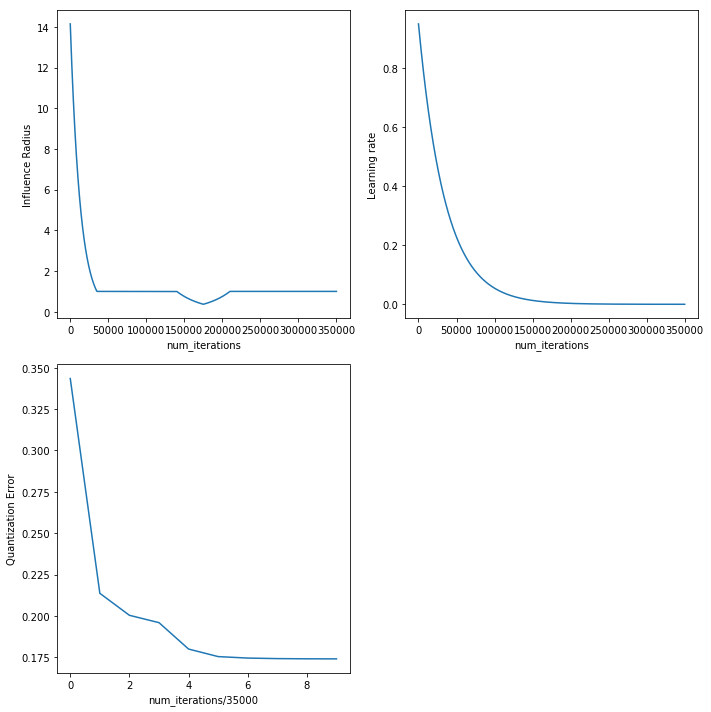

In [358]:
#Plot the hyerparameters and quantization error
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(221)
y =irad
x = nd.array(range(len(y)) )
ax.plot(x,y)
ax.set_xlabel('num_iterations')
ax.set_ylabel('Influence Radius')

ax1 = fig.add_subplot(222)
ax1.plot(x,eta)
ax1.set_xlabel('num_iterations')
ax1.set_ylabel('Learning rate')

ax2 = fig.add_subplot(223)
ax2.plot(np.array(range(len(mse))),mse)
ax2.set_xlabel('num_iterations/35000')
ax2.set_ylabel('Quantization Error')

plt.tight_layout()
plt.show()

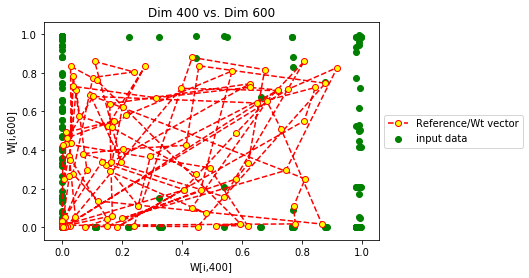

In [364]:
#Plot the neuron arrangement vs. the input data between 400 and 600th dimensions
x = [som.neuron_mat[i].codebook_vec[0][400] for i in range(som.no_neurons)]
y = [som.neuron_mat[i].codebook_vec[0][550] for i in range(som.no_neurons)]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y,color="red",linestyle='dashed',marker='o',markerfacecolor='yellow',label="Reference/Wt vector")
ax.scatter(x_train[400],x_train[550],color="green",label="input data")
ax.set_xlabel('W[i,400]')
ax.set_ylabel('W[i,600]')
ax.set_title('Dim 400 vs. Dim 600')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [371]:
#Function to evaluate accuracy on test data set
def evaluate_on_test(net,x_test,y_test,eta):
    mo = []
    gb = None
    gb_o = []
    mo = net.mapInput(x_test)
    gb = GrossbergLayer(net.no_neurons,10,eta)
    for i in range(x_test.shape[0]):
        iv = np.matrix(mo[i]).T
        gb_o = gb.generateResult(iv)
        gb.train(gb_o,nd.matrix(y_test[i]).T,iv)
    
    gb_o = gb.generateResult(mo.T)
    mse = np.sum(pow((y_test.T - gb_o).T,2))/len(y_test)
    acc = (nd.abs(gb_o.T-y_test).max(axis =1) < 0.05).sum()/len(x_test)
    print("QE = %0.2f    Accuracy = %0.2f" %(mse,acc))
    return (mo,gb_o)

In [380]:
#Function to create the cluster visulaization
def classPlot(net,output,target):
    temp = []
    for i in range(len(output)):
        bmu_ind = list(output[i]).index(1)
        temp.append([net.neuron_mat[bmu_ind].pos_x,net.neuron_mat[bmu_ind].pos_y, list(target[i]).index(1)])

    df = pd.DataFrame(temp)
    df.columns = ['x','y','c']

    colors = ['red','blue','green','yellow','orange','purple','black','pink','cyan','violet']
    map_cnt = df.groupby(['x','y']).count()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_yticks(ticks=range(np.max([np.shape(net.neuron_mat)])))
    ax.set_xticks(ticks=range(np.max([np.shape(net.neuron_mat)])))
    ax.set_title('Map of class output of each neuron of SOM')
    for name, group in df.groupby(['c']):
        ax.scatter(group['x'], group['y'],c=colors[name],marker=(4,0,0),label=name+1)
    plt.legend(loc='center left',title="Class Label",bbox_to_anchor=(1, 0.5))
    plt.show()

In [372]:
som_out,gb_out = evaluate_on_test(som,x_test,y_test,0.95)

QE = 0.39    Accuracy = 0.79


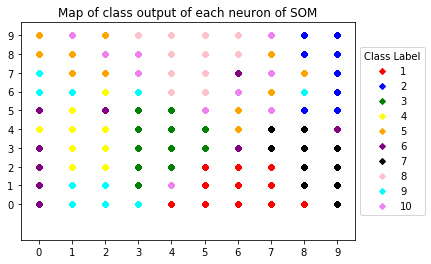

In [381]:
classPlot(som,som_out,np.round(gb_out.T))